This notebook aims to combine all necessary steps for each model of the combinations of all other ML models.

In [4]:
# first import the libraries
import pandas as pd
import numpy as np
from darts import TimeSeries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from darts.metrics import mape, r2_score, mase, mse
import sklearn
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, plotting, EfficientFrontier
#import copy
#import tabulate

AttributeError: partially initialized module 'pandas' has no attribute 'core' (most likely due to a circular import)

In [ ]:
# Filter out the FutureWarning message
warnings.filterwarnings("ignore", category=(FutureWarning))
warnings.filterwarnings("ignore", category=(UserWarning))
# get rid of the LinAlgWarning message
#from numpy.linalg import LinAlgWarning
#warnings.filterwarnings('ignore', category=LinAlgWarning)

NameError: name 'warnings' is not defined

Stored 'cum_returns' (DataFrame)


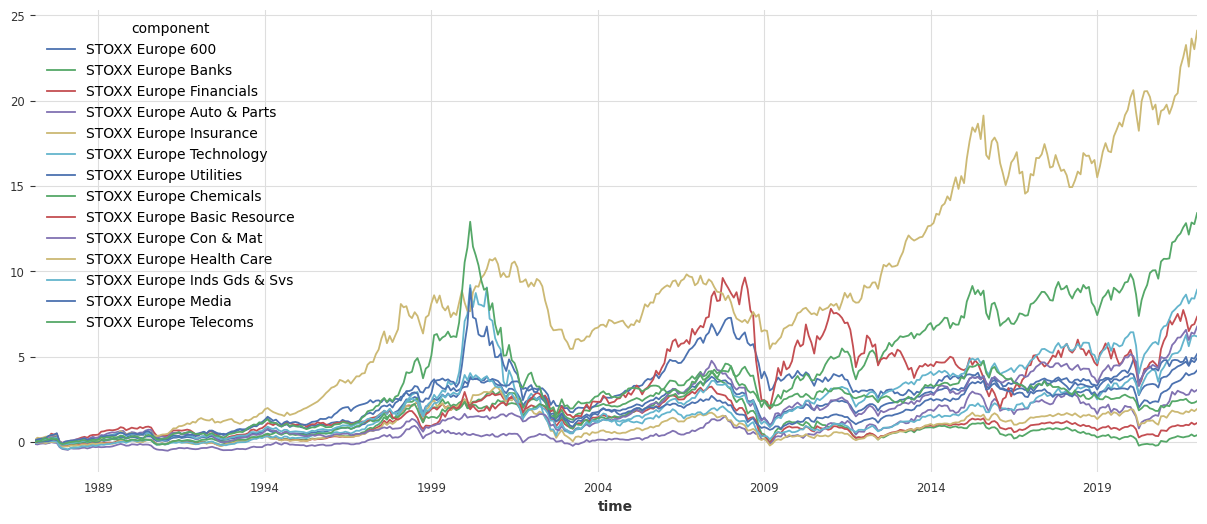

In [ ]:
# load the data, use Darts TimeSeries
ts = TimeSeries.from_csv('data/price_data_filtered.csv', parse_dates=True, index_col=0)
# compute monthly returns using pandas pct_change
returns = ts.pd_dataframe().pct_change().dropna()
# compute the cumulative monthly returns
cum_returns = (1 + returns).cumprod() - 1

cum_returns_portfolio = cum_returns
# store the cum_returns to use it in another notebook
%store cum_returns

# plot the cumulative returns
fig, ax = plt.subplots(figsize=(15, 6))
cum_returns.plot(ax=ax);
# to use the Darts models, we need to convert the data to a Darts TimeSeries
cum_returns = TimeSeries.from_dataframe(df = cum_returns,time_col= 0, fill_missing_dates=True)
# split the data into training and test set, use 80% for training
train, test = cum_returns.split_after(0.8)

## Benchmark Portfolios

### Equal Weighted Portfolio

In [ ]:
# create a list of the column names
col_list = list(cum_returns.columns)[1:]

# create weights
weights_ew = 1/len(col_list)

# print single weight and the sum of all weights
print('The weight for each stock is: ' + str(weights_ew))
print('The sum of all weights is: ' + str(weights_ew * 13))

# create a new column in cum_returns for the equal weighted portfolio
cum_returns_portfolio['equal_weighted'] = cum_returns_portfolio[col_list].mul(weights_ew).sum(axis=1)

# create a new variable called portfolio_returns with same structure as cum_returns
portfolio_returns = cum_returns_portfolio.copy()
# delete all columns except for the equal_weighted column
portfolio_returns.drop(cum_returns_portfolio.columns.difference(['equal_weighted']), 1, inplace=True)
portfolio_returns.tail()

# delete equal weighted column from cum_returns
cum_returns_portfolio.drop('equal_weighted', axis=1, inplace=True)

The weight for each stock is: 0.07692307692307693
The sum of all weights is: 1.0


/var/folders/jr/jvqd5mmj25sg1lj_gtw12nm00000gn/T/ipykernel_85770/4005426981.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  portfolio_returns.drop(cum_returns_portfolio.columns.difference(['equal_weighted']), 1, inplace=True)


### Portfolio based on Historical Average

In [ ]:
# Calculate average daily returns for each stock and exlude the first column
avg_returns = cum_returns_portfolio.mean()[1:]

# Calculate weights based on average daily returns
weights_ha = avg_returns / avg_returns.sum()

# Calculate portfolio returns
ha_returns = (cum_returns_portfolio * weights_ha).sum(axis=1)

# Add portfolio_returns as a new column in cum_returns
portfolio_returns['historical_average'] = ha_returns

# print single weight and the sum of all weights for historical average portfolio
print('The weight for each stock is: ' + str(weights_ha))
print('The sum of all weights is: ' + str(weights_ha.sum()))

The weight for each stock is: component
STOXX Europe Banks             0.033024
STOXX Europe Financials        0.030685
STOXX Europe Auto & Parts      0.021829
STOXX Europe Insurance         0.027747
STOXX Europe Technology        0.050778
STOXX Europe Utilities         0.085845
STOXX Europe Chemicals         0.108597
STOXX Europe Basic Resource    0.099537
STOXX Europe Con & Mat         0.061754
STOXX Europe Health Care       0.258600
STOXX Europe Inds Gds & Svs    0.076979
STOXX Europe Media             0.063096
STOXX Europe Telecoms          0.081530
dtype: float64
The sum of all weights is: 1.0


### Relevant functions

In [ ]:
def plot_efficient_frontier(mu, S, cum_returns_portfolio, title):
    ef = EfficientFrontier(mu, S)
    ef.add_constraint(lambda w: w[0] == 0.00)
    fig, ax = plt.subplots()
    ef_max_sharpe = ef.deepcopy()
    ef_min_vol = copy.deepcopy(ef)
    plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

    # Find the tangency portfolio with max Sharpe ratio
    ef_max_sharpe.max_sharpe()
    weights_max = ef_max_sharpe.clean_weights()
    ret_max = (cum_returns_portfolio * weights_max).sum(axis=1)
    std_max = ret_max.std()
    ax.scatter(std_max, ret_max.iloc[-1], marker="*", s=100, c="r", label="Max Sharpe")

    # Find the minimum volatility portfolio
    ef_min_vol.min_volatility()
    weights_min = ef_min_vol.clean_weights()
    ret_min = (cum_returns_portfolio * weights_min).sum(axis=1)
    std_min = ret_min.std()
    ax.scatter(std_min, ret_min.iloc[-1], marker="*", s=100, c="g", label="Min Volatility")    
    
    # compute the efficient frontier mathematically while using same optimization objective as the EfficientFrontier class without using pyportfolioopt
    """
    # Compute the efficient frontier
    """

    # save the return and volatility of max sharpe and min vola in two lists to a csv file naming them after mu

    
    
    # Generate random portfolios
    n_samples = 10000
    w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
    rets = w.dot(ef.expected_returns)
    stds = np.sqrt(np.diag(w @ S @ w.T))
    sharpes = rets / stds
    ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

    weights_max = pd.DataFrame.from_dict(weights_max, orient='index')
    weights_max.columns = ['Max Sharpe']
    weights_max = weights_max.T
    weights_min = pd.DataFrame.from_dict(weights_min, orient='index')
    weights_min.columns = ['Min Volatility']
    weights_min = weights_min.T
    
    
    # Generate a table with the weights of the max Sharpe ratio portfolio
    weights = pd.concat([weights_max, weights_min])
    # drop the rows with 0 weights in both portfolios
    weights = weights.loc[:, (weights != 0).any(axis=0)]
    # add a column that sums the weights per row
    weights['Sum'] = weights.sum(axis=1)

    # Display the clean table
    print("Weights:\n", weights.to_string(index=True, float_format='{:.2%}'.format))

    # Display the return and volatility of the max Sharpe ratio and min volatility portfolios
    performance = pd.DataFrame({"Return": [ret_max.iloc[-1]/100, ret_min.iloc[-1]/100],
                                "Volatility": [std_max/100, std_min/100]},
                               index=["Max Sharpe", "Min Volatility"])

    # Display the performance table
    print("\nPerformance:\n", performance.to_string(float_format='{:.2%}'.format))

    # Print table as LaTeX
    #print("\nWeights (LaTeX):\n", weights.transpose().to_latex(index=True, float_format='{:.2%}'.format))
    #print("\nPerformance (LaTeX):\n", performance.transpose().to_latex(float_format='{:.2%}'.format))

    # Output
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show();

In [ ]:
def generate_pie_chart(weights, title):
    cleaned_weights = {k: v for k, v in weights.items() if v > 1e-5}

    plt.figure(figsize=(10, 5))
    # Generate the pie chart without labels inside the slices
    wedges, _, _ = plt.pie(cleaned_weights.values(), labels=[''] * len(cleaned_weights), autopct='%1.2f%%', startangle=90)

    # Create a legend with the cleaned weights keys
    plt.legend(wedges, cleaned_weights.keys(), loc='upper left')

    # Create a legend with the cleaned weights keys
    plt.legend(wedges, cleaned_weights.keys(), loc='upper left')# Equal aspect ratio ensures that pie is drawn as a circle.
    plt.axis('equal')
    plt.title(title)
    plt.show();

#### Import all models retrieved

In [ ]:
# import the data of shrinkage, dimred and nonlinear as a dataframe
shrinkage = pd.read_csv('data/portfolio_returns_shrinkage.csv', index_col=0, parse_dates=True)
dimred = pd.read_csv('data/portfolio_returns_dimred.csv', index_col=0, parse_dates=True)
nonlinear = pd.read_csv('data/portfolio_returns_nonlinearML.csv', index_col=0, parse_dates=True)

In [ ]:
# drop equal weighted column and historical average column from dim_red
shrinkage.drop(['linear_regression_316', 'ridge_regression_316', 'lasso_regression_316', 'Elastic_Net_316', 'bridge_regression_1'], axis=1, inplace=True)
dimred.drop(['equal_weighted', 'historical_average', 'pls_regression_316'], axis=1, inplace=True)
nonlinear.drop(['equal_weighted', 'historical_average'], axis=1, inplace=True)

In [ ]:
shrinkage.tail()

,equal_weighted,historical_average,Bayesian Regression,linear_regression_1,ridge_regression_1,lasso_regression_1,Elastic_Net_1
time,,,,,,,
2021-09-01,6.334322,10.565259,21.757793,16.437078,23.264545,21.147879,21.147879
2021-10-01,5.926514,9.912039,20.570190,15.535738,21.991305,19.946396,19.946396
2021-11-01,6.322933,10.583310,22.082632,16.719975,23.637809,21.427089,21.427089
2021-12-01,6.237121,10.402550,21.532173,16.281709,23.011935,20.892168,20.892168
2022-01-01,6.544394,10.913366,22.553606,17.049796,24.096923,21.880713,21.880713


In [ ]:
# combine the dataframes
portfolio_returns = pd.concat([shrinkage, dimred, nonlinear], axis=1)

In [ ]:
# create model dataframe that drops the equal weighted and historical average columns
model = portfolio_returns.drop(['equal_weighted', 'historical_average'], axis=1)

In [ ]:
model

,Bayesian Regression,linear_regression_1,ridge_regression_1,lasso_regression_1,Elastic_Net_1,pls_regression_1,canonical_pls_1,cca_regression_1,random_forest_1,gradient_boosting_1,ada_boosting,extra_trees,epsilon_svm,nu_svm,MLP3
time,,,,,,,,,,,,,,,
1987-02-01,0.090402,0.056819,0.106993,0.092736,0.092736,-0.002170,0.002476,0.064696,0.106993,0.019786,0.008885,-0.008218,0.086738,0.071403,0.077319
1987-03-01,0.231412,0.161271,0.263403,0.233253,0.233253,0.040863,0.055564,0.173606,0.263402,0.115136,0.046786,0.041091,0.218681,0.184822,0.202310
1987-04-01,0.214536,0.155484,0.236597,0.218627,0.218627,0.066202,0.064552,0.170265,0.236596,0.119587,0.114258,0.083342,0.211339,0.192217,0.188625
1987-05-01,0.239991,0.184083,0.265967,0.252854,0.252854,0.111947,0.083224,0.201481,0.265966,0.156688,0.188116,0.085028,0.249894,0.237726,0.211455
1987-06-01,0.295255,0.222077,0.324009,0.307020,0.307020,0.135294,0.108535,0.240628,0.324008,0.188347,0.225461,0.124328,0.303663,0.288260,0.262611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,21.757793,16.437078,23.264545,21.147879,21.147879,5.996049,9.085169,14.642668,23.264445,8.645231,7.241773,12.830835,19.956515,17.452074,19.495646
2021-10-01,20.570190,15.535738,21.991305,19.946396,19.946396,5.579723,8.528113,13.847639,21.991211,8.123145,6.504457,12.154964,18.793920,16.373247,18.402493
2021-11-01,22.082632,16.719975,23.637809,21.427089,21.427089,5.931466,9.154632,14.831028,23.637708,8.430421,6.839178,12.867639,20.169595,17.543884,19.767314


In [ ]:
"""# save this as a csv file
portfolio_returns.to_csv('data/portfolio_returns_combination.csv', index=True, header=True)
model.to_csv('data/model.csv', index=True, header=True)
# import this csv file as a darts time series
portfolio_returns = TimeSeries.from_csv('data/portfolio_returns_combination.csv', index_col=0, parse_dates=True)
model = TimeSeries.from_csv('data/model.csv', index_col=0, parse_dates=True)"""

"# save this as a csv file\nportfolio_returns.to_csv('data/portfolio_returns_combination.csv', index=True, header=True)\nmodel.to_csv('data/model.csv', index=True, header=True)\n# import this csv file as a darts time series\nportfolio_returns = TimeSeries.from_csv('data/portfolio_returns_combination.csv', index_col=0, parse_dates=True)\nmodel = TimeSeries.from_csv('data/model.csv', index_col=0, parse_dates=True)"

### Equally-weighted average of ML forecasts (mean combination)

"Forecast combinations may be preferred over using forecasts based on individual models, since the latter could suffer from model uncertainty and instability, while combining different models can increase accuracy by including valuable information from each model."

&rarr; forecast combinations are the weighted averages of return forecasts from individual models

Two forecast combination approaches based on the type of models that are averaged:
1. combine simple bivariate prediction models based on individual predictors (We have not calculated bivariate prediction models)
2. combine the forecasts generated by machine learning models (we have computed 11)

&rarr; the mean combination (MC) sets the weight $\omega$<sub>1,t</sub> = 1/m for i = 1,2,...,m

In [ ]:
col_list_model = list(model.columns)

In [ ]:
# create weights
weights_ew_models = 1/len(col_list_model)

# print the single weight and the sum of all weights
print('The single weight is: ', weights_ew_models)
print('The sum of all weights is: ', weights_ew_models*len(col_list_model))

The single weight is:  0.06666666666666667
The sum of all weights is:  1.0


In [ ]:
# create a new csv file for the combination_returns
combination_returns = pd.DataFrame()

In [ ]:
# create a new column for the equal weighted combination portfolio
combination_returns['MC_ML'] = model.mul(weights_ew_models).sum(axis=1)

In [ ]:
print('The Return of the Mean Combination of all ML Models is: ' + str(round(combination_returns['MC_ML'].iloc[-1], 2)) + '%')

The Return of the Mean Combination of all ML Models is: 16.73%


### Trimmed mean combination of ML forecasts

&rarr; trimmed mean combination (TMC) sets $\omega$<sub>1,t</sub> = 0 for 5% of the forecasts with the lowest and highest values and $\omega$<sub>1,t</sub> = (1/ 0.9 * m) for the remaining forecasts.

In our case here, take remove the model with the best and the worst return.

In [ ]:
# which model has the highest return?
print('The model with the highest return is: ' + str(model.idxmax(axis=1).iloc[-1]))

# which model has the lowest return?
print('The model with the lowest return is: ' + str(model.idxmin(axis=1).iloc[-1]))

The model with the highest return is: ridge_regression_1
The model with the lowest return is: pls_regression_1


In [ ]:
# create col-list without these 2 models
col_list_trim = col_list_model.copy()
col_list_trim.remove('ridge_regression_1')
col_list_trim.remove('ada_boosting')

In [ ]:
# create weights
weights_trim = 1/len(col_list_trim)

# print the single weight and the sum of all weights
print('The single weight is: ', weights_trim)
print('The sum of all weights is: ', weights_trim*len(col_list_trim))

The single weight is:  0.07692307692307693
The sum of all weights is:  1.0


In [ ]:
# create a new column for the trimmed mean combination portfolio
combination_returns['TMC_ML'] = model[col_list_trim].mul(weights_trim).sum(axis=1)

In [ ]:
print('The Return of the Trimmed Mean Combination of all ML Models is: ' + str(round(combination_returns['TMC_ML'].iloc[-1], 2)) + '%')

The Return of the Trimmed Mean Combination of all ML Models is: 16.88%


### Weighted average of ML forecasts based on MSE ranking

"For the second type of forecasting methods, the combining weights are computed based on the historical forecasting performance of the individual models over the holdout period"

&rarr; method based on the rank of each model according to the mean squared forecast error (MSFE)

$$
\omega_{i, t}=\mathrm{RANK}_{i, t}^{-1} / \sum_{i=1}^m \mathrm{RANK}_{i, t}^{-1}
$$

In [ ]:
# import all evaluation metrics
ev_shrinkage = pd.read_csv('data/evaluation_shrinkage.csv', index_col=0, parse_dates=True)
ev_dimred = pd.read_csv('data/evaluation_dimred.csv', index_col=0, parse_dates=True)
ev_nonlinear = pd.read_csv('data/evaluation_nonlinear.csv', index_col=0, parse_dates=True)

ev_dimred = ev_dimred / 100

In [ ]:
ev_shrinkage

,MAPE,MSE,MAE,R2 Score
Portfolio,,,,
Linear Regression,0.187117,0.001076,0.002204,0.009222
Ridge Regression,0.082455,0.000993,0.002070,0.009070
Lasso Regression,0.152504,0.001050,0.002185,0.009256
Elastic Net,0.152504,0.001050,0.002185,0.009256
Bayesian Regression,0.085145,0.000994,0.002071,0.009073


In [ ]:
ev_dimred /100

,MAPE,MSE,MAE,R2 Score
Portfolio,,,,
PLS,0.174915,0.002643,0.003169,0.008465
PLS Canonical,0.082947,0.000972,0.002004,0.009195
CCA,0.121221,0.002158,0.002956,0.008689


In [ ]:
# create dictionary with all evaluation metrics
evaluation = {
    'Portfolio': [
        'Linear Regression',
        'Ridge Regression',
        'Lasso Regression',
        'Elastic Net',
        'Bayesian Regression',
        'PLS Regression',
        'Canonical PLS Regression',
        'CCA Regression',
        'Random Forest',
        'Gradient Boosting',
        'Ada Boosting',
        'Extra Trees',
        'Epsilon-Support Vector Regression',
        'Nu-Support Vector Regression',
        'MLP with 3 Layers'
    ],
    'MSE': [
            ev_shrinkage['MSE'][0],
             ev_shrinkage['MSE'][1],
            ev_shrinkage['MSE'][2],
            ev_shrinkage['MSE'][3],
            ev_shrinkage['MSE'][4],
            ev_dimred['MSE'][0],
            ev_dimred['MSE'][1],
            ev_dimred['MSE'][2],
            ev_nonlinear['MSE'][0],
            ev_nonlinear['MSE'][1],
            ev_nonlinear['MSE'][2],
            ev_nonlinear['MSE'][3],
            ev_nonlinear['MSE'][4],
            ev_nonlinear['MSE'][5],
            ev_nonlinear['MSE'][6]
    ],
    'MAPE': [
            ev_shrinkage['MAPE'][0],
                ev_shrinkage['MAPE'][1],
            ev_shrinkage['MAPE'][2],
            ev_shrinkage['MAPE'][3],
            ev_shrinkage['MAPE'][4],
            ev_dimred['MAPE'][0],
            ev_dimred['MAPE'][1],
            ev_dimred['MAPE'][2],
            ev_nonlinear['MAPE'][0],
            ev_nonlinear['MAPE'][1],
            ev_nonlinear['MAPE'][2],
            ev_nonlinear['MAPE'][3],
            ev_nonlinear['MAPE'][4],
            ev_nonlinear['MAPE'][5],
            ev_nonlinear['MAPE'][6]
    ],
    'MAE': [
            ev_shrinkage['MAE'][0],
                ev_shrinkage['MAE'][1],
            ev_shrinkage['MAE'][2],
            ev_shrinkage['MAE'][3],
            ev_shrinkage['MAE'][4],
            ev_dimred['MAE'][0],
            ev_dimred['MAE'][1],
            ev_dimred['MAE'][2],
            ev_nonlinear['MAE'][0],
            ev_nonlinear['MAE'][1],
            ev_nonlinear['MAE'][2],
            ev_nonlinear['MAE'][3],
            ev_nonlinear['MAE'][4],
            ev_nonlinear['MAE'][5],
            ev_nonlinear['MAE'][6]
    ],
    'R2': [
            ev_shrinkage['R2 Score'][0],
                ev_shrinkage['R2 Score'][1],
            ev_shrinkage['R2 Score'][2],
            ev_shrinkage['R2 Score'][3],
            ev_shrinkage['R2 Score'][4],
            ev_dimred['R2 Score'][0],
            ev_dimred['R2 Score'][1],
            ev_dimred['R2 Score'][2],
            ev_nonlinear['R2 Score'][0],
            ev_nonlinear['R2 Score'][1],
            ev_nonlinear['R2 Score'][2],
            ev_nonlinear['R2 Score'][3],
            ev_nonlinear['R2 Score'][4],
            ev_nonlinear['R2 Score'][5],
            ev_nonlinear['R2 Score'][6]
    ]
}

In [ ]:
# create a dataframe from the dictionary
evaluation = pd.DataFrame(evaluation)

# set the index to the portfolio names
evaluation.set_index('Portfolio', inplace=True)

# divide the vlues by 100 to get percentages
#evaluation[['MAPE', 'MSE', 'MAE', 'R2']] = evaluation[['MAPE', 'MSE', 'MAE', 'R2']].div(100)

# format the dataframe to display the values as percentages
evaluation.style.format("{:.2%}", subset=['MAPE', 'MSE', 'MAE', 'R2'])

,MSE,MAPE,MAE,R2
Portfolio,,,,
Linear Regression,0.11%,18.71%,0.22%,0.92%
Ridge Regression,0.10%,8.25%,0.21%,0.91%
Lasso Regression,0.11%,15.25%,0.22%,0.93%
Elastic Net,0.11%,15.25%,0.22%,0.93%
Bayesian Regression,0.10%,8.51%,0.21%,0.91%
PLS Regression,0.26%,17.49%,0.32%,0.85%
Canonical PLS Regression,0.10%,8.29%,0.20%,0.92%
CCA Regression,0.22%,12.12%,0.30%,0.87%
Random Forest,0.20%,13.01%,0.29%,0.79%


In [ ]:
# print this dataframe as a latex table
print(evaluation.to_latex(float_format="{:.2%}".format))

\begin{tabular}{lrrrr}
\toprule
{} &   MSE &   MAPE &   MAE &    R2 \\
Portfolio                         &       &        &       &       \\
\midrule
Linear Regression                 & 0.11\% & 18.71\% & 0.22\% & 0.92\% \\
Ridge Regression                  & 0.10\% &  8.25\% & 0.21\% & 0.91\% \\
Lasso Regression                  & 0.11\% & 15.25\% & 0.22\% & 0.93\% \\
Elastic Net                       & 0.11\% & 15.25\% & 0.22\% & 0.93\% \\
Bayesian Regression               & 0.10\% &  8.51\% & 0.21\% & 0.91\% \\
PLS Regression                    & 0.26\% & 17.49\% & 0.32\% & 0.85\% \\
Canonical PLS Regression          & 0.10\% &  8.29\% & 0.20\% & 0.92\% \\
CCA Regression                    & 0.22\% & 12.12\% & 0.30\% & 0.87\% \\
Random Forest                     & 0.20\% & 13.01\% & 0.29\% & 0.79\% \\
Gradient Boosting                 & 0.18\% & 18.95\% & 0.27\% & 0.88\% \\
Ada Boosting                      & 0.16\% & 23.28\% & 0.26\% & 0.89\% \\
Extra Trees                       & 

/var/folders/jr/jvqd5mmj25sg1lj_gtw12nm00000gn/T/ipykernel_85770/2336846463.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(evaluation.to_latex(float_format="{:.2%}".format))


In [ ]:
# show portfolio with lowest MSE
print('The portfolio with the lowest MSE is: ' + str(evaluation['MSE'].idxmin()))
# show portfolio with lowest MAPE
print('The portfolio with the lowest MAPE is: ' + str(evaluation['MAPE'].idxmin()))
# show portfolio with lowest MAE
print('The portfolio with the lowest MAE is: ' + str(evaluation['MAE'].idxmin()))
# show portfolio with highest R2
print('The portfolio with the highest R2 is: ' + str(evaluation['R2'].idxmax()))

The portfolio with the lowest MSE is: Canonical PLS Regression
The portfolio with the lowest MAPE is: Ridge Regression
The portfolio with the lowest MAE is: Canonical PLS Regression
The portfolio with the highest R2 is: Lasso Regression


In [ ]:
# show the 3 best portfolios
sorted_evaluation = evaluation.sort_values(by=['MSE', 'MAE', 'R2', 'MAPE'], ascending=[True, True, True, False]).head(3)
#format the dataframe to display the values as percentages
sorted_evaluation.style.format("{:.2%}", subset=['MAPE', 'MSE', 'MAE', 'R2'])

,MSE,MAPE,MAE,R2
Portfolio,,,,
Canonical PLS Regression,0.10%,8.29%,0.20%,0.92%
Ridge Regression,0.10%,8.25%,0.21%,0.91%
Bayesian Regression,0.10%,8.51%,0.21%,0.91%


In [ ]:
# print this dataframe as a latex table
print(sorted_evaluation.to_latex(float_format="{:.2%}".format))

\begin{tabular}{lrrrr}
\toprule
{} &   MSE &  MAPE &   MAE &    R2 \\
Portfolio                &       &       &       &       \\
\midrule
Canonical PLS Regression & 0.10\% & 8.29\% & 0.20\% & 0.92\% \\
Ridge Regression         & 0.10\% & 8.25\% & 0.21\% & 0.91\% \\
Bayesian Regression      & 0.10\% & 8.51\% & 0.21\% & 0.91\% \\
\bottomrule
\end{tabular}



/var/folders/jr/jvqd5mmj25sg1lj_gtw12nm00000gn/T/ipykernel_85770/1185901037.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(sorted_evaluation.to_latex(float_format="{:.2%}".format))


In [ ]:
# create dataframe with all evaluation metrics
mse_df = pd.DataFrame(mse)

# set the index to the portfolio
mse_df.set_index('Portfolio', inplace=True)

# create a second column that asign a rank according to the MSE
mse_df['Rank'] = mse_df['MSE'].rank()

# format the dataframe such that the rank is an integer
mse_df.style.format({'MSE': '{:.2%}', 'Rank': '{:.0f}'})


,MSE,Rank
Portfolio,,
Linear Regression,0.11%,6
Ridge Regression,0.10%,2
Lasso Regression,0.11%,4
Elastic Net,0.11%,4
Bridge Regression,0.10%,3
PLS Regression,0.26%,13
Canonical PLS Regression,0.10%,1
CCA Regression,0.22%,12
Random Forest,0.20%,11


In [ ]:
# sum of all ranks
mse_df['Rank'].sum()

120.0

In [ ]:
# compute the weights
# the weight followings the formula: rank/sum of all ranks

# create a new column for the weights such that the smallest rank has the highest weight
# compute the inverse of the rank
mse_df['Inverse_Rank'] = 1/mse_df['Rank']
mse_df['Weight'] = mse_df['Inverse_Rank']/mse_df['Inverse_Rank'].sum()

# print the dataframe
mse_df.style.format({'MSE': '{:.2%}', 'Rank': '{:.0f}', 'Weight': '{:.3%}'})

,MSE,Rank,Inverse_Rank,Weight
Portfolio,,,,
Linear Regression,0.11%,6,0.166667,5.031%
Ridge Regression,0.10%,2,0.500000,15.094%
Lasso Regression,0.11%,4,0.222222,6.708%
Elastic Net,0.11%,4,0.222222,6.708%
Bridge Regression,0.10%,3,0.333333,10.062%
PLS Regression,0.26%,13,0.076923,2.322%
Canonical PLS Regression,0.10%,1,1.000000,30.187%
CCA Regression,0.22%,12,0.083333,2.516%
Random Forest,0.20%,11,0.090909,2.744%


In [ ]:
# sum of the weight column
mse_df['Weight'].sum()

0.9999999999999998

In [ ]:
model

,Bayesian Regression,linear_regression_1,ridge_regression_1,lasso_regression_1,Elastic_Net_1,pls_regression_1,canonical_pls_1,cca_regression_1,random_forest_1,gradient_boosting_1,ada_boosting,extra_trees,epsilon_svm,nu_svm,MLP3
time,,,,,,,,,,,,,,,
1987-02-01,0.090402,0.056819,0.106993,0.092736,0.092736,-0.002170,0.002476,0.064696,0.106993,0.019786,0.008885,-0.008218,0.086738,0.071403,0.077319
1987-03-01,0.231412,0.161271,0.263403,0.233253,0.233253,0.040863,0.055564,0.173606,0.263402,0.115136,0.046786,0.041091,0.218681,0.184822,0.202310
1987-04-01,0.214536,0.155484,0.236597,0.218627,0.218627,0.066202,0.064552,0.170265,0.236596,0.119587,0.114258,0.083342,0.211339,0.192217,0.188625
1987-05-01,0.239991,0.184083,0.265967,0.252854,0.252854,0.111947,0.083224,0.201481,0.265966,0.156688,0.188116,0.085028,0.249894,0.237726,0.211455
1987-06-01,0.295255,0.222077,0.324009,0.307020,0.307020,0.135294,0.108535,0.240628,0.324008,0.188347,0.225461,0.124328,0.303663,0.288260,0.262611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,21.757793,16.437078,23.264545,21.147879,21.147879,5.996049,9.085169,14.642668,23.264445,8.645231,7.241773,12.830835,19.956515,17.452074,19.495646
2021-10-01,20.570190,15.535738,21.991305,19.946396,19.946396,5.579723,8.528113,13.847639,21.991211,8.123145,6.504457,12.154964,18.793920,16.373247,18.402493
2021-11-01,22.082632,16.719975,23.637809,21.427089,21.427089,5.931466,9.154632,14.831028,23.637708,8.430421,6.839178,12.867639,20.169595,17.543884,19.767314


In [ ]:
#multiply the returns of each model with the corresponding weight
# create a new dataframe
model_weighted = model.copy()

# multiply each column with the corresponding weight
for i in range(len(mse_df)):
    model_weighted.iloc[:, i] = model_weighted.iloc[:, i].mul(mse_df['Weight'][i])

# create a new column for the weighted mean combination portfolio
combination_returns['WMC_ML'] = model_weighted.sum(axis=1)

print('The Return of the Weighted average of ML forecasts based on MSE ranking is: ' + str(round(combination_returns['WMC_ML'].iloc[-1], 2)) + '%')

# import the evaluation metrics for the equal weighted combination portfolio

The Return of the Weighted average of ML forecasts based on MSE ranking is: 15.8%


### Average of ML forecasts contained in the first of two clusters

"Aiolfi and Timmermann (2006) also consider a clustering approach to combine forecasts. Specifically, the forecasts from the individual models are grouped into L equal-sized clusters based on their past MSFE performance, with the first cluster containing the models with the lowest MSFE. Each combination forecast is the average of the individual forecasts contained in the first cluster. This procedure starts with the initial holdout period and then goes through the end of the available OOS period using a rolling window. We consider forecast combinations with two (CL2) and three (CL3) clusters."

In [ ]:
# clustering into 2 and 3 clusters
cluster_2 = int(len(model.columns) / 2)
cluster_3 = int(len(model.columns) / 3)

In [ ]:
print('The number of models for 2 clusters is: ' + str(cluster_2))
print('The number of models for 3 clusters is: ' + str(cluster_3))

The number of models for 2 clusters is: 7
The number of models for 3 clusters is: 5


#### CL2

In [ ]:
# sort all mse_df by rank
mse_df.sort_values(by=['Rank'], inplace=True)
mse_df

,MSE,Rank,Inverse_Rank,Weight
Portfolio,,,,
Canonical PLS Regression,0.000972,1.0,1.000000,0.301871
Ridge Regression,0.000993,2.0,0.500000,0.150935
Bridge Regression,0.000994,3.0,0.333333,0.100624
Lasso Regression,0.001050,4.5,0.222222,0.067082
Elastic Net,0.001050,4.5,0.222222,0.067082
Linear Regression,0.001076,6.0,0.166667,0.050312
MLP with 3 Layers,0.001193,7.0,0.142857,0.043124
Nu-Support Vector Regression,0.001523,8.0,0.125000,0.037734
Ada Boosting,0.001637,9.0,0.111111,0.033541


In [ ]:
# get the 5 models with the lowest rank according to the mse_df

cl2 = mse_df.sort_values(by=['Rank']).head(cluster_2).index

In [ ]:
print(cl2)

Index(['Canonical PLS Regression', 'Ridge Regression', 'Bridge Regression',
       'Lasso Regression', 'Elastic Net', 'Linear Regression',
       'MLP with 3 Layers'],
      dtype='object', name='Portfolio')


In [ ]:
cl2 = ['Bayesian Regression', 'canonical_pls_1', 'ridge_regression_1', 'lasso_regression_1', 'Elastic_Net_1', 'linear_regression_1', 'MLP3']

In [ ]:
# For CL2:
combination_returns['CL2'] = model[cl2].mean(axis=1)


In [ ]:
print('The Return of the Cluster 2 Combination of all ML Models is: ' + str(round(combination_returns['CL2'].iloc[-1], 2)) + '%')

The Return of the Cluster 2 Combination of all ML Models is: 19.59%


#### CL3

In [ ]:
cl3 = mse_df.sort_values(by=['Rank']).head(cluster_3).index

In [ ]:
print(cl3)

Index(['Canonical PLS Regression', 'Ridge Regression', 'Bridge Regression',
       'Lasso Regression', 'Elastic Net'],
      dtype='object', name='Portfolio')


In [ ]:
cl3 = ['Bayesian Regression', 'canonical_pls_1', 'ridge_regression_1', 'lasso_regression_1', 'Elastic_Net_1']

In [ ]:
# For CL3:
combination_returns['CL3'] = model[cl3].mean(axis=1)

In [ ]:
print('The Return of the Cluster 3 Combination of all ML Models is: ' + str(round(combination_returns['CL3'].iloc[-1], 2)) + '%')

The Return of the Cluster 3 Combination of all ML Models is: 19.97%


### Discounted mean square forecast error, ψ = 1, of ML forecasts


$$
\omega_{i, t}=\varphi_{i, t}^{-1} / \sum_{i=1}^m \varphi_{i, t}^{-1}, \text { where } \varphi_{i, t}=\sum_{s=R}^{t-1} \psi^{t-1-q_0}\left(r_{s+1}-\widehat{r}_{i, s+1}\right)^2
$$

# Outcome Combination Portfolio Building

In [ ]:
combination_returns.tail()

,MC_ML,TMC_ML,WMC_ML,CL2,CL3
time,,,,,
2021-09-01,16.157705,16.296866,15.252884,18.905141,19.280653
2021-10-01,15.219263,15.368706,14.371103,17.845805,18.196480
2021-11-01,16.297831,16.460806,15.418515,19.173791,19.545850
2021-12-01,15.947631,16.099099,15.070667,18.697714,19.063111
2022-01-01,16.725718,16.880164,15.803729,19.588245,19.971837


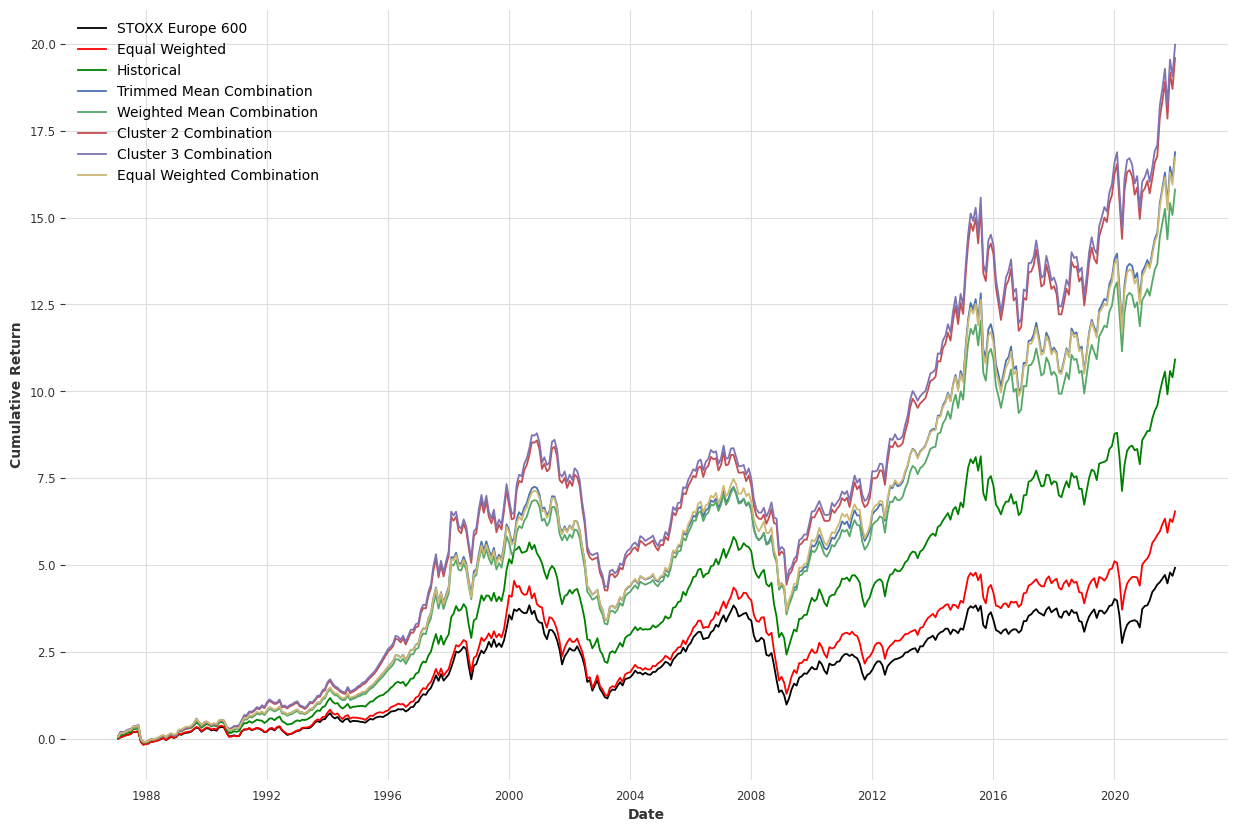

In [ ]:
# plot all the cumulative returns
plt.figure(figsize=(15, 10))
plt.plot(cum_returns_portfolio['STOXX Europe 600'], color= 'black', label='STOXX Europe 600')
plt.plot(portfolio_returns['equal_weighted'], color= 'red', label='Equal Weighted')
plt.plot(portfolio_returns['historical_average'], color= 'green', label='Historical')
plt.plot(combination_returns['TMC_ML'], label='Trimmed Mean Combination')
plt.plot(combination_returns['WMC_ML'], label='Weighted Mean Combination')
plt.plot(combination_returns['CL2'], label='Cluster 2 Combination')
plt.plot(combination_returns['CL3'], label='Cluster 3 Combination')
plt.plot(combination_returns['MC_ML'], label='Equal Weighted Combination')
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show();

In [ ]:
# create dictionary with the data
data = {
    'Portfolio': [
        'STOXX Europe 600',
        'Equal Weighted',
        'Historical Average',
        'Trimmed Mean Combination',
        'Weighted Mean Combination',
        'Cluster 2 Combination',
        'Cluster 3 Combination',
        'Equal Weighted Combination'
    ],
    'Return': [
        round(cum_returns_portfolio['STOXX Europe 600'].iloc[-1], 2),
        round(portfolio_returns['equal_weighted'].iloc[-1], 2),
        round(portfolio_returns['historical_average'].iloc[-1], 2),
        round(combination_returns['TMC_ML'].iloc[-1], 2),
        round(combination_returns['WMC_ML'].iloc[-1], 2),
        round(combination_returns['CL2'].iloc[-1], 2),
        round(combination_returns['CL3'].iloc[-1], 2),
        round(combination_returns['MC_ML'].iloc[-1], 2)
    ],
    'Volatility': [
        round(cum_returns_portfolio['STOXX Europe 600'].std(), 2),
        round(portfolio_returns['equal_weighted'].std(), 2),
        round(portfolio_returns['historical_average'].std(), 2),
        round(combination_returns['TMC_ML'].std(), 2),
        round(combination_returns['WMC_ML'].std(), 2),
        round(combination_returns['CL2'].std(), 2),
        round(combination_returns['CL3'].std(), 2),
        round(combination_returns['MC_ML'].std(), 2)
    ],
}

In [ ]:
# create a dataframe from the dictionary
df = pd.DataFrame(data)

# divide the return column by 100
df['Return'] = df['Return']/100
df['Volatility'] = df['Volatility']/100

# set the index to the portfolio names
df.set_index('Portfolio', inplace=True)

# format the return and volatility columns using style.format
df.style.format({'Return': '{:.2%}', 'Volatility': '{:.2%}'})

,Return,Volatility
Portfolio,,
STOXX Europe 600,4.92%,1.31%
Equal Weighted,6.54%,1.63%
Historical Average,10.91%,2.67%
Trimmed Mean Combination,16.88%,4.15%
Weighted Mean Combination,15.80%,3.90%
Cluster 2 Combination,19.59%,4.87%
Cluster 3 Combination,19.97%,4.96%
Equal Weighted Combination,16.73%,4.11%


In [ ]:
# print this in latex
print(df.to_latex(float_format='{:.2%}'.format))

\begin{tabular}{lrr}
\toprule
{} &  Return &  Volatility \\
Portfolio                  &         &             \\
\midrule
STOXX Europe 600           &   4.92\% &       1.31\% \\
Equal Weighted             &   6.54\% &       1.63\% \\
Historical Average         &  10.91\% &       2.67\% \\
Trimmed Mean Combination   &  16.88\% &       4.15\% \\
Weighted Mean Combination  &  15.80\% &       3.90\% \\
Cluster 2 Combination      &  19.59\% &       4.87\% \\
Cluster 3 Combination      &  19.97\% &       4.96\% \\
Equal Weighted Combination &  16.73\% &       4.11\% \\
\bottomrule
\end{tabular}



/var/folders/jr/jvqd5mmj25sg1lj_gtw12nm00000gn/T/ipykernel_85770/1370785696.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(float_format='{:.2%}'.format))


In [ ]:
# combine models and combination portfolios
all_models = pd.concat([model, combination_returns], axis=1)


In [ ]:
all_models.tail()

,Bayesian Regression,linear_regression_1,ridge_regression_1,lasso_regression_1,Elastic_Net_1,pls_regression_1,canonical_pls_1,cca_regression_1,random_forest_1,gradient_boosting_1,ada_boosting,extra_trees,epsilon_svm,nu_svm,MLP3,MC_ML,TMC_ML,WMC_ML,CL2,CL3
time,,,,,,,,,,,,,,,,,,,,
2021-09-01,21.757793,16.437078,23.264545,21.147879,21.147879,5.996049,9.085169,14.642668,23.264445,8.645231,7.241773,12.830835,19.956515,17.452074,19.495646,16.157705,16.296866,15.252884,18.905141,19.280653
2021-10-01,20.570190,15.535738,21.991305,19.946396,19.946396,5.579723,8.528113,13.847639,21.991211,8.123145,6.504457,12.154964,18.793920,16.373247,18.402493,15.219263,15.368706,14.371103,17.845805,18.196480
2021-11-01,22.082632,16.719975,23.637809,21.427089,21.427089,5.931466,9.154632,14.831028,23.637708,8.430421,6.839178,12.867639,20.169595,17.543884,19.767314,16.297831,16.460806,15.418515,19.173791,19.545850
2021-12-01,21.532173,16.281709,23.011935,20.892168,20.892168,5.880249,8.987110,14.489136,23.011835,8.408096,6.914244,12.766185,19.688436,17.172285,19.286738,15.947631,16.099099,15.070667,18.697714,19.063111
2022-01-01,22.553606,17.049796,24.096923,21.880713,21.880713,6.169976,9.447232,15.148888,24.096819,8.930109,7.346715,13.416273,20.638707,18.020565,20.208734,16.725718,16.880164,15.803729,19.588245,19.971837


In [ ]:
# create a new table containing return and volatility of all models and combination portfolios
data = {
    'Portfolio': ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Elastic Net', 'Bayesian Regression' ,'PLS', 'PLS Canonical', 'CCA',
                  'Random Forest', 'Gradient Boosting', 'Ada Boosting', 'Extremely Randomized Trees', 'Epsilon SVM', 'Nu SVM', 'MLP 3 hidden layers',
                  'Trimmed Mean Combination', 'Weighted Mean Combination', 'Cluster 2 Combination', 'Cluster 3 Combination', 'Equal Weighted Combination'],
    'Return': [all_models['linear_regression_1'].tail(1).values[0],
                all_models['ridge_regression_1'].tail(1).values[0],
                all_models['lasso_regression_1'].tail(1).values[0],
                all_models['Elastic_Net_1'].tail(1).values[0],
                all_models['Bayesian Regression'].tail(1).values[0],
                all_models['pls_regression_1'].tail(1).values[0],
                all_models['canonical_pls_1'].tail(1).values[0],
                all_models['cca_regression_1'].tail(1).values[0],
                all_models['random_forest_1'].tail(1).values[0],
                all_models['gradient_boosting_1'].tail(1).values[0],
                all_models['ada_boosting'].tail(1).values[0],
                all_models['extra_trees'].tail(1).values[0],
                all_models['epsilon_svm'].tail(1).values[0],
                all_models['nu_svm'].tail(1).values[0],
                all_models['MLP3'].tail(1).values[0],
                all_models['TMC_ML'].tail(1).values[0],
                all_models['WMC_ML'].tail(1).values[0],
                all_models['CL2'].tail(1).values[0],
                all_models['CL3'].tail(1).values[0],
                all_models['MC_ML'].tail(1).values[0]
    ],
    'Volatility': [all_models['linear_regression_1'].std(),
                all_models['ridge_regression_1'].std(),
                all_models['lasso_regression_1'].std(),
                all_models['Elastic_Net_1'].std(),
                all_models['Bayesian Regression'].std(),
                all_models['pls_regression_1'].std(),
                all_models['canonical_pls_1'].std(),
                all_models['cca_regression_1'].std(),
                all_models['random_forest_1'].std(),
                all_models['gradient_boosting_1'].std(),
                all_models['ada_boosting'].std(),
                all_models['extra_trees'].std(),
                all_models['epsilon_svm'].std(),
                all_models['nu_svm'].std(),
                all_models['MLP3'].std(),
                all_models['TMC_ML'].std(),
                all_models['WMC_ML'].std(),
                all_models['CL2'].std(),
                all_models['CL3'].std(),
                all_models['MC_ML'].std()
    ]
}
                
# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Divide the values by 100 to get the percentage
df[['Return', 'Volatility']] = df[['Return', 'Volatility']].div(100)

# Set the index of the DataFrame to be the Portfolio column
df.set_index('Portfolio', inplace=True)

# Format the DataFrame to display the values as percentages
df.style.format("{:.2%}", subset=['Return', 'Volatility'])

,Return,Volatility
Portfolio,,
Linear Regression,17.05%,4.25%
Ridge Regression,24.10%,6.03%
Lasso Regression,21.88%,5.44%
Elastic Net,21.88%,5.44%
Bayesian Regression,22.55%,5.62%
PLS,6.17%,1.61%
PLS Canonical,9.45%,2.32%
CCA,15.15%,3.76%
Random Forest,24.10%,6.03%


In [ ]:
# sort this table according to the return
df.sort_values(by=['Return'], inplace=True, ascending=False)

# display the table
df.style.format("{:.2%}", subset=['Return', 'Volatility'])

,Return,Volatility
Portfolio,,
Ridge Regression,24.10%,6.03%
Random Forest,24.10%,6.03%
Bayesian Regression,22.55%,5.62%
Lasso Regression,21.88%,5.44%
Elastic Net,21.88%,5.44%
Epsilon SVM,20.64%,5.12%
MLP 3 hidden layers,20.21%,5.03%
Cluster 3 Combination,19.97%,4.96%
Cluster 2 Combination,19.59%,4.87%


In [ ]:
# show only the first 10 models of this table in the same way
df.head(10).style.format("{:.2%}", subset=['Return', 'Volatility'])

,Return,Volatility
Portfolio,,
Ridge Regression,24.10%,6.03%
Random Forest,24.10%,6.03%
Bayesian Regression,22.55%,5.62%
Lasso Regression,21.88%,5.44%
Elastic Net,21.88%,5.44%
Epsilon SVM,20.64%,5.12%
MLP 3 hidden layers,20.21%,5.03%
Cluster 3 Combination,19.97%,4.96%
Cluster 2 Combination,19.59%,4.87%


In [ ]:
# print this table in latex
print(df.to_latex(float_format='{:.2%}'.format))

\begin{tabular}{lrr}
\toprule
{} &  Return &  Volatility \\
Portfolio                  &         &             \\
\midrule
Ridge Regression           &  24.10\% &       6.03\% \\
Random Forest              &  24.10\% &       6.03\% \\
Bayesian Regression        &  22.55\% &       5.62\% \\
Lasso Regression           &  21.88\% &       5.44\% \\
Elastic Net                &  21.88\% &       5.44\% \\
Epsilon SVM                &  20.64\% &       5.12\% \\
MLP 3 hidden layers        &  20.21\% &       5.03\% \\
Cluster 3 Combination      &  19.97\% &       4.96\% \\
Cluster 2 Combination      &  19.59\% &       4.87\% \\
Nu SVM                     &  18.02\% &       4.45\% \\
Linear Regression          &  17.05\% &       4.25\% \\
Trimmed Mean Combination   &  16.88\% &       4.15\% \\
Equal Weighted Combination &  16.73\% &       4.11\% \\
Weighted Mean Combination  &  15.80\% &       3.90\% \\
CCA                        &  15.15\% &       3.76\% \\
Extremely Randomized Trees &  13.42\%

/var/folders/jr/jvqd5mmj25sg1lj_gtw12nm00000gn/T/ipykernel_85770/3349196764.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(float_format='{:.2%}'.format))


In [ ]:
# get the shrinkag
                